In [2]:
import numpy as np
import dask.array as da
# from TFilterPy.base_estimator import BaseEstimator

import numpy as np
import dask.array as da

class BaseEstimator:
    """
    Base class for all estimators in the TFilterPy package.
    Provides common functionality such as parameter handling and validation.
    """

    def __init__(self, name=None):
        """
        Initialize the BaseEstimator.

        Args:
            name (str): Optional name for the estimator.
        """
        self.name = name or self.__class__.__name__

    @staticmethod
    def to_dask_array(numpy_array, chunk_size=None):
        """
        Convert a NumPy array to a Dask array with specified chunking.
        If chunk_size is None, use Dask's automatic chunking.
        
        Parameters:
            numpy_array (np.ndarray): Input array.
            chunk_size (int or tuple, optional): Desired chunk size.
            
        Returns:
            da.Array: Dask array version of numpy_array.
        """
        if chunk_size is None:
            return da.from_array(numpy_array, chunks="auto")
        else:
            # If a single integer is provided, use it for all dimensions.
            if isinstance(chunk_size, int):
                chunks = tuple(chunk_size for _ in range(numpy_array.ndim))
            else:
                chunks = chunk_size
            return da.from_array(numpy_array, chunks=chunks)
    
    def get_params(self, deep=True):
        """
        Get parameters of the estimator.

        Args:
            deep (bool): If True, retrieves parameters of nested objects.

        Returns:
            dict: A dictionary of parameter names mapped to their values.
        """
        params = {}
        for key, value in self.__dict__.items():
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                params.update({f"{key}__{k}": v for k, v in deep_items})
            else:
                params[key] = value
        return params

    def set_params(self, **params):
        """
        Set parameters of the estimator.

        Args:
            **params: Arbitrary keyword arguments of parameters to set.

        Returns:
            self: Returns the instance itself.
        """
        for key, value in params.items():
            if not hasattr(self, key):
                raise ValueError(f"Invalid parameter: {key}")
            setattr(self, key, value)
        return self

    def validate_matrices(self, matrices):
        """
        Validate that matrices have consistent shapes.

        Args:
            matrices (dict): A dictionary of matrix names and their values.

        Raises:
            ValueError: If the matrices are inconsistent.
        """
        for name, matrix in matrices.items():
            if not isinstance(matrix, (np.ndarray, da.Array)):
                raise ValueError(f"{name} must be a NumPy or Dask array.")

    def __repr__(self):
        """
        String representation of the estimator.

        Returns:
            str: A string representation of the estimator.
        """
        return f"{self.name}({self.get_params(deep=False)})"


In [4]:
import dask
print(dask.__version__)

2024.8.0


In [2]:
import dask.array as da
import numpy as np

class ParameterEstimator(BaseEstimator):
    r"""
    A class for estimating Kalman Filter parameters, such as process noise covariance (Q)
    and observation noise covariance (R), using different estimation methods.

    Estimation strategies include:
    - Residual Analysis
    - Maximum Likelihood Estimation (MLE)
    - Cross-Validation
    - Adaptive Filtering

    References:
    - Welch, G., & Bishop, G. (1995). An Introduction to the Kalman Filter.
    - Haykin, S. (2001). Kalman Filtering and Neural Networks.
    """

    def __init__(self, estimation_strategy: str = "residual_analysis"):
        r"""
        Initialize the ParameterEstimator with the desired estimation strategy.

        Parameters
        ----------
        estimation_strategy : str, optional
            The strategy to use for estimating parameters. Options include:
            - "residual_analysis": Estimate based on residuals after running the filter.
            - "mle": Maximum Likelihood Estimation (iterative approach).
            - "cross_validation": Perform k-fold cross-validation for best Q and R.
            - "adaptive_filtering": Dynamically update Q and R based on measurement residuals.

        Raises
        ------
        ValueError
            If an invalid estimation strategy is specified.
        """
        super().__init__(name="KalmanFilterParameterEstimator")
        valid_strategies = {
            "residual_analysis",
            "mle",
            "cross_validation",
            "adaptive_filtering",
        }
        if estimation_strategy not in valid_strategies:
            raise ValueError(
                f"Invalid strategy: {estimation_strategy}. Must be one of {valid_strategies}."
            )
        self.estimation_strategy = estimation_strategy

    def estimate_with_residual_analysis(self, measurements: da.Array) -> tuple:
        r"""
        Estimate process (Q) and observation (R) noise covariances using residual analysis.
        """
        state_estimates, residuals = self.run_filter(measurements)
        Q = da.cov(residuals, rowvar=False)
        # Use auto chunking for the identity matrix
        R = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
        return Q, R

    def estimate_with_mle(self, measurements: da.Array, max_iterations: int = 5) -> tuple:
        r"""
        Estimate Q and R using Maximum Likelihood Estimation (MLE).
        """
        Q, R = self.Q, self.R

        for _ in range(max_iterations):
            state_estimates, residuals = self.run_filter(measurements)
            # Use "auto" chunking for the identity matrices
            Q_new = da.eye(residuals.shape[1], chunks="auto") * da.var(residuals, axis=0)
            R_new = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            # Persist intermediate results to avoid recomputation overhead
            Q, R = Q_new.persist(), R_new.persist()

        return Q, R

    def estimate_with_cross_validation(self, measurements: da.Array, k_folds: int = 5) -> tuple:
        r"""
        Estimate Q and R using k-fold cross-validation.
        """
        n_samples = measurements.shape[0]
        fold_size = n_samples // k_folds

        fold_scores, fold_Qs, fold_Rs = [], [], []

        for fold in range(k_folds):
            val_start = fold * fold_size
            val_end = val_start + fold_size
            train_data = da.concatenate([measurements[:val_start], measurements[val_end:]])
            val_data = measurements[val_start:val_end]

            state_estimates, residuals = self.run_filter(train_data)
            val_score = da.mean((val_data - state_estimates[:fold_size]) ** 2)
            fold_scores.append(val_score)

            Q_fold = da.cov(residuals.T)
            R_fold = da.eye(self.R.shape[0], chunks="auto") * da.var(residuals)
            fold_Qs.append(Q_fold)
            fold_Rs.append(R_fold)

        # Compute all folds lazily and choose the best fold
        fold_scores, fold_Qs, fold_Rs = da.compute(fold_scores, fold_Qs, fold_Rs)
        best_fold = np.argmin(fold_scores)
        return fold_Qs[best_fold], fold_Rs[best_fold]

    def estimate_with_adaptive_filtering(self, measurements: da.Array) -> tuple:
        r"""
        Estimate Q and R adaptively based on innovations over time.
        """
        Q, R = self.Q, self.R
        alpha = 0.01
        innovations = measurements - da.dot(self.H, self.x)
        outer_products = da.einsum("ij,ik->ijk", innovations, innovations)
        Q_new = da.mean(outer_products, axis=0).rechunk("auto")
        R_new = da.var(innovations, axis=0).rechunk("auto")

        Q = (1 - alpha) * Q + alpha * Q_new
        R = (1 - alpha) * R + alpha * R_new
        return Q, R

    def estimate_parameters(self, measurements: da.Array):
        r"""
        Estimate the parameters Q and R using the specified estimation strategy.
        """
        return getattr(self, f"estimate_with_{self.estimation_strategy}")(measurements)


In [3]:
# import numpy as np
# import dask.array as da
# from TFilterPy.utils.optimisation_utils import ParameterEstimator

class DaskParticleFilter(ParameterEstimator):
    """
    A multivariate, scalable particle filter using Dask. Inherits parameter estimation 
    methods from ParameterEstimator.
    """
    def __init__(self, state_transition, observation_model, process_noise_cov, 
                 observation_noise_cov, initial_state, num_particles=1000, use_dask=True, 
                 estimation_strategy="residual_analysis"):
        """
        Initialize the DaskParticleFilter. In addition to particle filter parameters, 
        we specify whether to use Dask for scalability and which parameter estimation 
        strategy to use.
        """
        # Initialize the ParameterEstimator
        super().__init__(estimation_strategy=estimation_strategy)
        self.use_dask = use_dask
        self.state_dim = initial_state.shape[0]
        self.num_particles = num_particles

        # Convert inputs to Dask arrays if scalability is desired
        if self.use_dask:
            self.state_transition = da.from_array(state_transition, chunks=state_transition.shape)
            self.observation_model = da.from_array(observation_model, chunks=observation_model.shape)
            self.process_noise_cov = da.from_array(process_noise_cov, chunks=process_noise_cov.shape)
            self.observation_noise_cov = da.from_array(observation_noise_cov, chunks=observation_noise_cov.shape)
            self.initial_state = da.from_array(initial_state, chunks=initial_state.shape)
        else:
            self.state_transition = state_transition
            self.observation_model = observation_model
            self.process_noise_cov = process_noise_cov
            self.observation_noise_cov = observation_noise_cov
            self.initial_state = initial_state

        # Step 1: Initialization - all particles start at the same known state
        particles_np = np.repeat(initial_state.reshape(1, self.state_dim), num_particles, axis=0)
        if self.use_dask:
            self.particles = da.from_array(particles_np, chunks=(num_particles // 10, self.state_dim))
        else:
            self.particles = particles_np
        
        # Uniform weights
        weights_np = np.ones(num_particles) / num_particles
        if self.use_dask:
            self.weights = da.from_array(weights_np, chunks=(num_particles // 10,))
        else:
            self.weights = weights_np

        # Current state estimate (initially set to the initial state)
        self.state = self.initial_state.compute() if self.use_dask else self.initial_state

        # For parameter estimation methods, we store a copy of Q and R (could be updated later)
        # For demonstration, we initialize them as given.
        self.Q = self.process_noise_cov
        self.R = self.observation_noise_cov

    def predict(self):
        """
        Step 2: Prediction. Propagate each particle using the state transition model plus 
        Gaussian process noise.
        """
        noise_np = np.random.multivariate_normal(
            np.zeros(self.state_dim),
            self.process_noise_cov.compute() if self.use_dask else self.process_noise_cov,
            self.num_particles
        )
        if self.use_dask:
            noise = da.from_array(noise_np, chunks=self.particles.chunksize)
        else:
            noise = noise_np
        
        if self.use_dask:
            self.particles = da.dot(self.particles, self.state_transition.T) + noise
            self.particles = self.particles.persist()
        else:
            self.particles = (self.state_transition @ self.particles.T).T + noise

    def update(self, measurement):
        """
        Step 3: Measurement Update. Update particle weights based on the likelihood 
        of the observed measurement.
        
        Parameters:
            measurement (np.ndarray): The observed measurement.
        """
        if self.use_dask and not isinstance(measurement, da.Array):
            measurement = da.from_array(measurement, chunks=measurement.shape)
        
        if self.use_dask:
            predicted_measurements = da.dot(self.particles, self.observation_model.T)
        else:
            predicted_measurements = (self.observation_model @ self.particles.T).T
        
        diff = predicted_measurements - measurement
        
        R_val = self.observation_noise_cov[0, 0].compute() if self.use_dask else self.observation_noise_cov[0, 0]
        if self.use_dask:
            likelihood = da.exp(-0.5 * da.sum(diff**2, axis=1) / R_val)
        else:
            likelihood = np.exp(-0.5 * np.sum(diff**2, axis=1) / R_val)
        
        self.weights = self.weights * likelihood
        self.weights = self.weights + 1e-300  # Avoid zero weights
        self.weights = self.weights / self.weights.sum()
        
        self.resample()
        self.estimate_state()

    def resample(self):
        """
        Step 4: Resampling. Multinomial resampling to refocus on high-probability particles.
        """
        weights_np = self.weights.compute() if self.use_dask else self.weights
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=weights_np)
        if self.use_dask:
            particles_np = self.particles.compute()
            particles_resampled = particles_np[indices]
            self.particles = da.from_array(particles_resampled, chunks=self.particles.chunksize)
            self.weights = da.from_array(np.ones(self.num_particles) / self.num_particles, chunks=self.weights.chunksize)
        else:
            self.particles = self.particles[indices]
            self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate_state(self):
        """
        Step 5: State Estimation. Compute the state estimate as the weighted average of particles.
        """
        if self.use_dask:
            self.state = da.average(self.particles, weights=self.weights, axis=0).compute()
        else:
            self.state = np.average(self.particles, weights=self.weights, axis=0)

    def step(self, measurement):
        """
        Step 6: Iteration. Run one full filter cycle: predict, update, resample, and state estimation.
        
        Parameters:
            measurement (np.ndarray): The observed measurement.
        
        Returns:
            np.ndarray: The estimated state.
        """
        self.predict()
        self.update(measurement)
        return self.state

    def run_filter(self, measurements):
        """
        This method is required for parameter estimation routines. It should run the filter 
        over a sequence of measurements and return both the state estimates and the residuals.
        
        Parameters:
            measurements (da.Array): Array of measurements over time, shape (n_timesteps, n_obs).
        
        Returns:
            state_estimates (da.Array): Filtered state estimates, shape (n_timesteps, n_state).
            residuals (da.Array): Residuals (measurement - predicted_measurement), same shape as measurements.
        
        For this simple example, we run the filter sequentially over the measurements.
        """
        n_timesteps = measurements.shape[0]
        state_estimates = []
        residuals = []
        for i in range(n_timesteps):
            meas = measurements[i]
            # Predict and update for current measurement
            self.step(meas)
            state_estimates.append(self.state)
            # Compute predicted measurement from the current state estimate
            if self.use_dask:
                pred_meas = da.dot(da.from_array(self.state, chunks=self.state.shape), self.observation_model.T).compute()
            else:
                pred_meas = self.observation_model @ self.state
            # Residual is difference between actual measurement and predicted measurement
            res = (meas.compute() if self.use_dask else meas) - pred_meas
            residuals.append(res)
        # Convert lists to dask arrays (or numpy arrays)
        state_estimates = da.from_array(np.vstack(state_estimates)) if self.use_dask else np.vstack(state_estimates)
        residuals = da.from_array(np.vstack(residuals)) if self.use_dask else np.vstack(residuals)
        return state_estimates, residuals

# # Example usage:
# if __name__ == '__main__':
#     # Define a simple 2D state model (position and velocity)
#     F = np.array([[1, 1],
#                   [0, 1]])
#     H = np.array([[1, 0]])  # Only position is measured

#     # Define noise covariances
#     Q = np.eye(2) * 0.01
#     R = np.eye(1) * 0.1

#     initial_state = np.array([0, 1])

#     # Create the particle filter instance with Dask enabled
#     pf = DaskParticleFilter(F, H, Q, R, initial_state, num_particles=1000, use_dask=True, estimation_strategy="residual_analysis")

#     # Simulate some measurements over 10 time steps
#     true_state = initial_state.copy()
#     measurements_list = []
#     np.random.seed(42)
#     for _ in range(10):
#         true_state = F @ true_state
#         measurement = H @ true_state + np.random.normal(0, np.sqrt(R[0, 0]))
#         measurements_list.append(measurement)
#     measurements_array = da.from_array(np.vstack(measurements_list), chunks=(5, H.shape[0]))

#     # Run the filter over these measurements (for parameter estimation, run_filter is used)
#     state_estimates, residuals = pf.run_filter(measurements_array)
#     print("Final estimated state:", pf.state)

#     # Use one of the parameter estimation methods (e.g., residual_analysis)
#     Q_est, R_est = pf.estimate_parameters(measurements_array)
#     print("Estimated Q:", Q_est.compute() if pf.use_dask else Q_est)
#     print("Estimated R:", R_est.compute() if pf.use_dask else R_est)


_______

# ComputerVision 
- Image Denoising
____

Train MSE: 44.0367
Test MSE: 36.3831


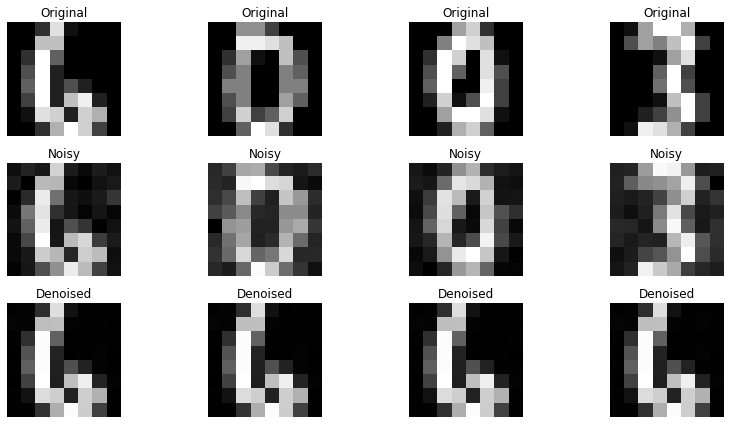

Classification Accuracy: 0.0806


C:\Users\thabanglukhetho\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
# from your_module import DaskParticleFilter  # Adjust import

# Load and split the digits dataset (20 samples)
digits = load_digits()
x = digits.data[0:2000]  # Shape: (20, 64)
y = digits.target[0:2000]  # Shape: (20,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 16 samples
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 4 samples
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# Add synthetic noise
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)
noisy_x_test_dask = x_test_dask + da.random.normal(0, noise_level, x_test_dask.shape, chunks=x_test_dask.chunks)

# Particle Filter Setup
n_features = 64  # 8x8 pixels
F = np.eye(n_features)  # Static transition
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = x_train[0]     # First clean image as initial guess

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# Denoise Training and Test Sets
train_states, _ = pf.run_filter(noisy_x_train_dask)
denoised_x_train = train_states.compute()  # Shape: (16, 64)

# Reinitialize for test set (optional: could reuse same filter state)
pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=x_test[0],  # First test image
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)
test_states, _ = pf.run_filter(noisy_x_test_dask)
denoised_x_test = test_states.compute()  # Shape: (4, 64)

# Evaluate Denoising
mse_train = np.mean((x_train - denoised_x_train) ** 2)
mse_test = np.mean((x_test - denoised_x_test) ** 2)
print(f"Train MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")

# Visualize (first 4 training images)
n_display = 4
plt.figure(figsize=(12, 6))
for i in range(n_display):
    # Original
    plt.subplot(3, n_display, i + 1)
    plt.imshow(x_train[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    # Noisy
    plt.subplot(3, n_display, i + 1 + n_display)
    plt.imshow(noisy_x_train_dask[i].compute().reshape(8, 8), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')
    # Denoised
    plt.subplot(3, n_display, i + 1 + 2 * n_display)
    plt.imshow(denoised_x_train[i].reshape(8, 8), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Optional: Classification
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(denoised_x_train, y_train)
y_pred = clf.predict(denoised_x_test)
accuracy = np.mean(y_pred == y_test)
print(f"Classification Accuracy: {accuracy:.4f}")

# Multi-variate Time Series

Data shape: (9000, 14)
Mean Squared Error: 23324209.7518


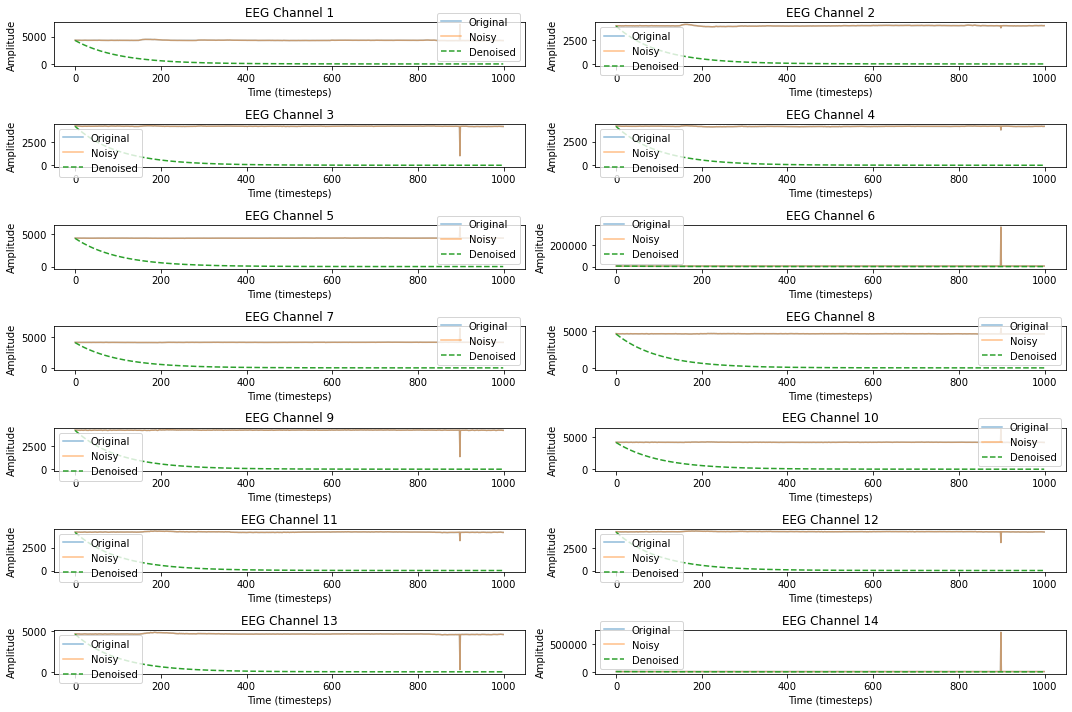

In [5]:
from sklearn.datasets import fetch_openml
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
# from your_module import DaskParticleFilter  # Adjust import

# 1. Load EEG Eye State data
data = fetch_openml(name='eeg-eye-state', version=1, as_frame=False)
X = data.data[0:9000]  # Shape: (14980, 14)
X_dask = da.from_array(X, chunks=(1000, 14))
print(f"Data shape: {X_dask.shape}")

# 2. Add Synthetic Noise
noise_level = 0.5  # Adjust noise intensity
noisy_X_dask = X_dask + da.random.normal(0, noise_level, X_dask.shape, chunks=X_dask.chunks)

# 3. Particle Filter Setup
n_features = 14  # 14 EEG channels
F = np.eye(n_features) * 0.99  # Slow drift (near-static transition)
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = X[0]           # First timestep as initial state

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# 4. Run Filter to Denoise
state_estimates, residuals = pf.run_filter(noisy_X_dask)
denoised_X = state_estimates.compute()  # Shape: (14980, 14)

# 5. Evaluate
mse = np.mean((X - denoised_X) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# 6. Visualize (first 1000 timesteps, all channels)
subset_size = 1000
X_subset = X[:subset_size]
noisy_subset = noisy_X_dask[:subset_size].compute()
denoised_subset = denoised_X[:subset_size]

plt.figure(figsize=(15, 10))
for i in range(14):
    plt.subplot(7, 2, i + 1)
    plt.plot(X_subset[:, i], label="Original", alpha=0.5)
    plt.plot(noisy_subset[:, i], label="Noisy", alpha=0.5)
    plt.plot(denoised_subset[:, i], label="Denoised", linestyle="--")
    plt.title(f"EEG Channel {i+1}")
    plt.xlabel("Time (timesteps)")
    plt.ylabel("Amplitude")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import dask.array as da
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
# from your_module import DaskParticleFilter  # Adjust import

# 1. Load Disaster Tweets
data_path = r'C:\Users\thabanglukhetho\Documents\gits\tfilterPy\examples\data\train_nlp.csv'
df = pd.read_csv(data_path)
tweets = df['text'].values[0:5000]  # 500 tweets for testing
print(f"Number of tweets: {len(tweets)}")

# 2. Preprocess and Extract Topics
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(tweets)
n_topics = 5  # e.g., disaster, weather, casual, news, other
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_dist = lda.fit_transform(X)  # Shape: (500, 5)
X_dask = da.from_array(topic_dist, chunks=(100, n_topics))  # Adjusted chunks for 500 samples
print(f"Topic distribution shape: {X_dask.shape}")

# 3. Particle Filter Setup
F = np.eye(n_topics) * 0.95  # Slight decay for smooth topic evolution
H = np.eye(n_topics)  # Direct observation
Q = np.eye(n_topics) * 0.01  # Process noise
R = np.eye(n_topics) * 0.1   # Observation noise
initial_state = topic_dist[0]  # First tweet’s topics

pf = DaskParticleFilter(
    state_transition=F,
    observation_model=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=initial_state,
    num_particles=1000,
    use_dask=True,
    estimation_strategy="residual_analysis"
)

# 4. Run Filter to Track Topics
state_estimates, residuals = pf.run_filter(X_dask)
smoothed_topics = state_estimates.compute()  # Shape: (500, 5)

# 5. Plot Raw vs Smoothed Topics (first 500 tweets)
subset_size = 500  # Full set since we’re using 500 tweets
plt.figure(figsize=(12, 8))
for i in range(n_topics):
    plt.subplot(n_topics, 1, i + 1)
    plt.plot(topic_dist[:subset_size, i], label=f"Raw Topic {i+1}", alpha=0.5)
    plt.plot(smoothed_topics[:subset_size, i], label=f"Filtered Topic {i+1}", linestyle="--")
    plt.title(f"Topic {i+1}")
    plt.xlabel("Tweet Index (Time)")
    plt.ylabel("Probability")
    plt.legend()
plt.tight_layout()
plt.show()

# 6. Interpret Topics
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-5:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

# 7. Optional: Check Final State and Parameters
print("Final estimated state:", pf.state)
Q_est, R_est = pf.estimate_parameters(X_dask)
print("Estimated Q:", Q_est.compute())
print("Estimated R:", R_est.compute())

Number of tweets: 5000
Topic distribution shape: (5000, 5)


In [ ]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from your_module import DaskParticleFilter  # Adjust import
import time

# 1. Load and split the digits dataset (20 samples)
digits = load_digits()
x = digits.data[0:2000]  # Shape: (20, 64)
y = digits.target[0:2000]  # Shape: (20,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 16 samples
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 4 samples
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# 2. Add Synthetic Noise
noise_level = 0.88
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)

# 3. Particle Filter Setup (common parameters)
n_features = 64
F = np.eye(n_features)  # Static transition
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
initial_state = x_train[0]     # First clean image

# Strategies to benchmark (adjust if ParameterEstimator has different options)
strategies = ["residual_analysis",
            "mle",
            "cross_validation",
            "adaptive_filtering"]

# 4. Benchmark Execution Time
results = {}
denoised_results = {}
for strategy in strategies:
    print(f"Running strategy: {strategy}")
    pf = DaskParticleFilter(
        state_transition=F,
        observation_model=H,
        process_noise_cov=Q,
        observation_noise_cov=R,
        initial_state=initial_state,
        num_particles=1000,
        use_dask=True,
        estimation_strategy=strategy
    )
    
    start_time = time.time()
    state_estimates, _ = pf.run_filter(noisy_x_train_dask)
    denoised_x_train = state_estimates.compute()  # Shape: (16, 64)
    end_time = time.time()
    
    execution_time = end_time - start_time
    results[strategy] = execution_time
    denoised_results[strategy] = denoised_x_train
    print(f"{strategy} execution time: {execution_time:.2f} seconds")

# 5. Report Results
print("\nBenchmark Results:")
for strategy, exec_time in results.items():
    print(f"{strategy}: {exec_time:.2f} seconds")

# 6. Evaluate Denoising (MSE for each strategy)
for strategy, denoised_x_train in denoised_results.items():
    mse = np.mean((x_train - denoised_x_train) ** 2)
    print(f"MSE ({strategy}): {mse:.4f}")

# # 7. Visualize (first 4 training images, both strategies)
# n_display = 4
# plt.figure(figsize=(12, 8))
# for i in range(n_display):
#     # Original
#     plt.subplot(3, n_display, i + 1)
#     plt.imshow(x_train[i].reshape(8, 8), cmap='gray')
#     plt.title("Original")
#     plt.axis('off')
#     # Noisy
#     plt.subplot(3, n_display, i + 1 + n_display)
#     plt.imshow(noisy_x_train_dask[i].compute().reshape(8, 8), cmap='gray')
#     plt.title("Noisy")
#     plt.axis('off')
#     # Denoised (residual_analysis)
#     plt.subplot(3, n_display, i + 1 + 2 * n_display)
#     plt.imshow(denoised_results["residual_analysis"][i].reshape(8, 8), cmap='gray')
#     plt.title("Denoised (residual)")
#     plt.axis('off')
# plt.figure(figsize=(12, 4))
# for i in range(n_display):
#     # Denoised (em)
#     plt.subplot(1, n_display, i + 1)
#     plt.imshow(denoised_results["em"][i].reshape(8, 8), cmap='gray')
#     plt.title("Denoised (em)")
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [ ]:
import matplotlib.pyplot as plt


# Extract strategies and times
strategies = list(results.keys())
times = list(results.values())

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(strategies, times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Estimation Strategy')
plt.ylabel('Execution Time (seconds)')
plt.title('Benchmark: Execution Time per Estimation Strategy (Digits Dataset)')
# plt.ylim(1.7, 1.8)  # Narrow y-axis for better comparison
for i, v in enumerate(times):
    plt.text(i, v + 0.002, f"{v:.4f}", ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()